<img style="float: left;" src="earth-lab-logo-rgb.png" width="150" height="150" />

# Earth Analytics Education

# LiDAR Uncertainty at SOAP and SJER NEON sites

## The Soap Site
![Soaproot panorama](img/Soaproot_pano.jpeg)
Image Credit: National Ecological Observation Network, available at https://www.neonscience.org/field-sites/soap

## The SJER Site
![SJER panorama](img/sjer_site.jpeg)
Image Credit: National Ecological Observation Network, available at https://www.neonscience.org/field-sites/sjer

In [1]:
import os
import pathlib

import earthpy as et 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterstats as rs
import xarray as xr
import rioxarray as rxr
import seaborn as sns

import clean

# download the data from EarthPy
et.data.get_data('spatial-vector-lidar')

# set home directory
home_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'spatial-vector-lidar'
)
os.chdir(home_dir)   

In [8]:
# Create dir and path variables
# SJER paths
sjer_based_dir = os.path.join('california','neon-sjer-site')
sjer_insitu_path = os.path.join(sjer_based_dir, '2013',
                                'insitu',
                                'veg_structure',
                                'D17_2013_SJER_vegStr.csv')
sjer_plots_path = os.path.join(sjer_based_dir,
                              'vector_data',
                               'SJER_plot_centroids.shp')
sjer_chm_path = os.path.join(sjer_based_dir, '2013',
                             'lidar',
                             'sjer_lidarCHM.tif')
# SOAP paths
soap_based_dir = os.path.join('california','neon-soap-site')

soap_insitu_path = os.path.join(soap_based_dir, '2013',
                                'insitu',
                                'veg-structure',
                                'D17_2013_SOAP_vegStr.csv')
soap_plots_path = os.path.join(soap_based_dir,
                              'vector_data',
                               'SOAP_centroids.shp')
soap_chm_path = os.path.join(soap_based_dir, '2013',
                             'lidar',
                             'SOAP_lidarCHM.tif')


In [16]:
def calc_lidar_chm_stats(plots_path, chm_path):
    """
    Calculate max and mean tree height from LiDAR.
    """
    # Calculate the plot perimeters
    plots_gdf = gpd.read_file(plots_path)
    plots_gdf.geometry = plots_gdf.geometry.buffer(20)

    # Calculate the zonal stats
    chm_stats = rs.zonal_stats(
        plots_gdf, 
        chm_path,
        stats=['mean', 'max'],
        geojson_out=True,
        nodata=0,
        copy_properties=True
    )
    chm_stats_gdf = gpd.GeoDataFrame.from_features(chm_stats)
    lidar_mean_max = chm_stats_gdf.rename(
        columns={'max':'lidar_max', 'mean':'lidar_mean'},
        inplace=True)
    return chm_stats_gdf

sjer_lidar_chm_stats_gdf = calc_lidar_chm_stats(sjer_plots_path, sjer_chm_path)
sjer_lidar_chm_stats_gdf.head()
   

,geometry,Plot_ID,Point,northing,easting,plot_type,lidar_max,lidar_mean
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,19.049999,11.544347
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,24.019999,10.369277
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,16.070000,7.518398
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,11.059999,7.675346
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,5.740000,4.591177


In [17]:
soap_lidar_chm_stats_gdf = calc_lidar_chm_stats(
    soap_plots_path, soap_chm_path)
soap_lidar_chm_stats_gdf.head()

,geometry,OBJECTID,ID,plotType,subtype,plotDimens,Protocols,lidar_max,lidar_mean
0,"POLYGON ((297815.197 4101493.028, 297815.101 4...",1,27,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",50.250000,20.455827
1,"POLYGON ((297065.197 4100713.028, 297065.101 4...",2,43,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",54.099998,19.804080
2,"POLYGON ((299825.197 4101013.028, 299825.101 4...",3,63,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",32.480000,16.989834
3,"POLYGON ((298175.197 4101433.028, 298175.101 4...",4,91,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",50.309998,21.980976
4,"POLYGON ((298715.197 4100833.028, 298715.101 4...",5,95,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",33.869999,17.412048


In [31]:
def calc_insitu_height_stats(insitu_path):
    """Calculate insitu tree height data max and mean."""
    # Load in insitu data
    insitu_df = (pd.read_csv(insitu_path)
                  .groupby('plotid')
                  .stemheight
                  .agg(['max','mean'])
                 .rename(columns={
                         'max':'insitu_max', 'mean':'insitu_mean'}))
    return insitu_df

sjer_insitu_df = calc_insitu_height_stats(sjer_insitu_path)
sjer_insitu_df.head()

,insitu_max,insitu_mean
plotid,,
SJER1068,19.3,3.866667
SJER112,23.9,8.221429
SJER116,16.0,8.218750
SJER117,11.0,6.512500
SJER120,8.8,7.600000


In [32]:
soap_insitu_df = calc_insitu_height_stats(soap_insitu_path)
soap_insitu_df.head()

,insitu_max,insitu_mean
plotid,,
SOAP1343,6.5,2.112500
SOAP139,120.0,4.745902
SOAP143,19.7,2.530702
SOAP1515,3.4,1.776923
SOAP1563,1.9,1.071429


In [40]:
def calc_height_stats(
    plots_path, chm_path, insitu_path, id_col='Plot_ID'):
    """Calculate lidar and insitu height stats on a merged dataframe."""
    chm_stats_gdf = calc_lidar_chm_stats(
        plots_path=plots_path, 
        chm_path=chm_path)
    insitu_height_df = calc_insitu_height_stats(
        insitu_path=insitu_path)
    
    stat_df = chm_stats_gdf.merge(insitu_height_df, right_index=True,
                                   left_on=id_col)
    
    return stat_df

sjer_df = calc_height_stats(
    sjer_plots_path, sjer_chm_path, sjer_insitu_path)
sjer_df.head()

,geometry,Plot_ID,Point,northing,easting,plot_type,lidar_max,lidar_mean,insitu_max,insitu_mean
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,19.049999,11.544347,19.3,3.866667
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,24.019999,10.369277,23.9,8.221429
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,16.070000,7.518398,16.0,8.218750
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,11.059999,7.675346,11.0,6.512500
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,5.740000,4.591177,8.8,7.600000


In [43]:
# soap_df = calc_height_stats(
#     soap_plots_path,soap_chm_path, soap_insitu_path)
# soap_df

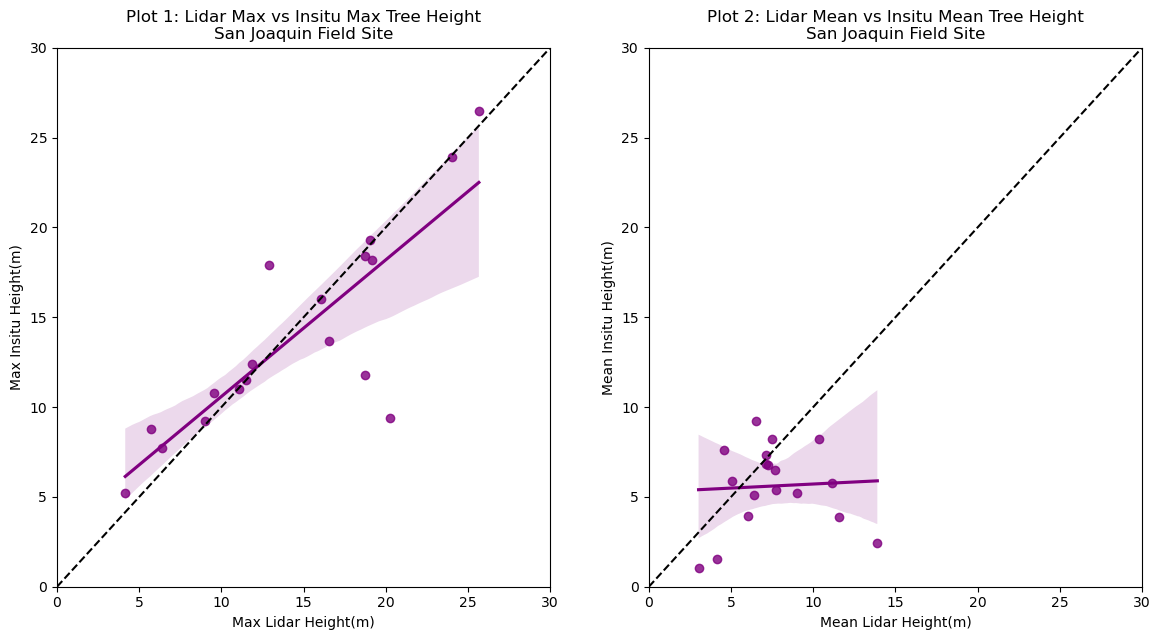

In [46]:
def plot_comparisons(merged_df):
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14, 7))
    # ax1.scatter(sjer_df.lidar_mean, sjer_df.insitu_mean)
    sns.regplot(data=merged_df, x='lidar_max',y='insitu_max', 
               color='purple',
               ax=ax1)
    ax1.plot((0,1), (0,1), transform=ax1.transAxes, ls='--', c='k')
    ax1.set(xlabel='Max Lidar Height(m)',ylabel='Max Insitu Height(m)',
           title=('Plot 1: Lidar Max vs Insitu Max Tree Height\n'
                 'San Joaquin Field Site'),
           ylim=(0,30),
           xlim=(0,30))

    sns.regplot(data=merged_df, x='lidar_mean',y='insitu_mean', 
               color='purple',
               ax=ax2)
    ax2.set(xlabel='Mean Lidar Height(m)',ylabel='Mean Insitu Height(m)',
           title=('Plot 2: Lidar Mean vs Insitu Mean Tree Height\n'
                 'San Joaquin Field Site'),
            ylim=(0,30),
            xlim=(0,30))
    ax2.plot((0,1), (0,1), transform=ax2.transAxes, ls='--', c='k')
    
sjer_plots = plot_comparisons(sjer_df)
    

In [45]:
soap_plots = plot_comparisons(soap_merged_df)

NameError: name 'soap_merged_df' is not defined